In [5]:
from other_methods_implemenations  import *
import pandas as pd
import numpy as np


c:\Users\mikol\Desktop\Master thesis\mcut_feature_selection\mcut_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
df = pd.read_pickle('../data/broaded_df').dropna()

In [7]:
train = df.loc['2021':'2022']
test = df.loc['2023':'2023-3']

In [40]:
res4 = pd.Series()
mcut_feature_selection(df, 1, 'marg', np.mean, 7, mcut, 0, 100, 5)
for i in range(4,5):
    start = pd.Timestamp.now(tz = 'cet')
    feats = mcut_feature_selection(train, 4, 'marg', np.mean, 7, mcut, i, 100, 5)
    res4.loc[f'folds_{i}'] = ((pd.Timestamp.now(tz = 'cet') - start).total_seconds(), len(feats), feats)
    # res4.to_pickle('../experiments_results/experiment_4_results.pkl')
    del feats


Max condition is abs(mono)>0.8999999999999999
Number of features is 164
I saved it as 'results'.


I saved importantn features due to the Lasso regression as an attribute 'important_features'.


In [42]:
res4

folds_4    (2134.465807, 15, [feat_70_rolling_7_mean, fea...
dtype: object

In [9]:
# res4.to_pickle('../experiments_results/experiment_4_results.pkl')

In [8]:
import datetime as dt
import pandas as pd
import statsmodels.api as sm

def backtest_OLS(df, cols):
    
    d = df[cols + ['marg']].dropna()
    d['pred_OLS'] = np.nan
    pvs = pd.DataFrame(columns=cols)
    
    for date in pd.date_range('2022-12-31', '2023-04-01', freq='D', tz = 'CET'):

        start_date = date - dt.timedelta(days = 365)

        train = d.loc[(start_date) : (date - dt.timedelta(1) - dt.timedelta(hours=1))][cols + ['marg']].dropna()
        test = d.loc[(date+dt.timedelta(days=1)):(date +dt.timedelta(days=1) +dt.timedelta(hours=23))]
        
        if (train.empty) | (test.empty):
            continue
        
        model = sm.OLS(train.marg, train[cols]).fit()
        d.loc[test.index,'pred_OLS'] = model.predict(test[cols])
        pvs.loc[date] = model.pvalues
        
    return d, pvs

In [9]:
res4 = pd.read_pickle('../experiments_results/experiment_4_results.pkl')

In [10]:
import numpy as np

In [11]:
r = pd.Series()
df_test = test.copy()
for i in range(5):
     df_test['preds'] = backtest_OLS(df, res4[f'folds_{i}'][2])[0].pred_OLS
     df_test['pnl'] = np.sign(df_test.preds) * df_test.marg
     r[f'fold_{i}'] = df_test.pnl[df_test.pnl>0].sum()/df_test.pnl.abs().sum()


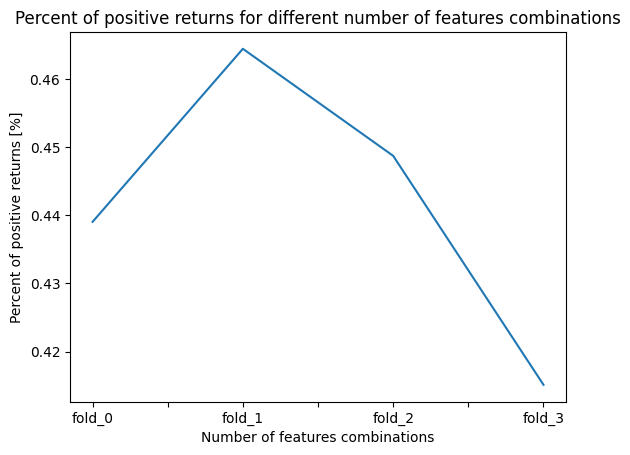

In [17]:
r.head(4).plot()
import matplotlib.pyplot as plt
plt.title('Percent of positive returns for different number of features combinations')
plt.xlabel('Number of features combinations')
plt.ylabel('Percent of positive returns [%]')
plt.savefig('../charts/exp4_marg.png', format='png')


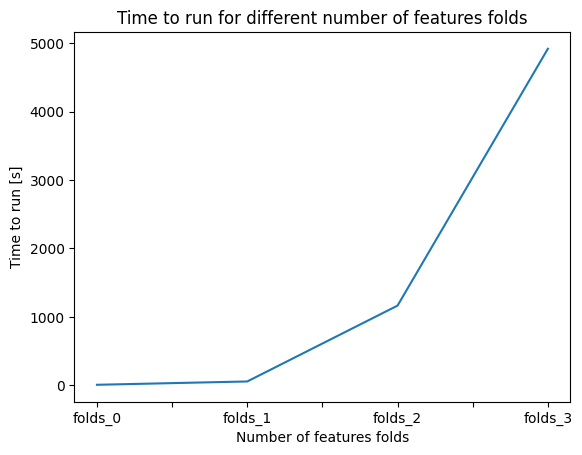

In [18]:
res4.head(4).apply(lambda x: x[0]).plot()
plt.title('Time to run for different number of features folds')
plt.xlabel('Number of features folds')
plt.ylabel('Time to run [s]')
plt.savefig('../charts/exp4_time.png', format='png')

